In [17]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Device ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# === Config ===
image_dir = "./7272660"
img_size = (224, 224)
batch_size = 32
num_epochs = 20
output_dim = 3

# === Transformations ===
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Dataset ===
dataset = ImageFolder(image_dir, transform=transform)
class_names = dataset.classes
targets = [label for _, label in dataset]
class_weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# === Train/Val/Test Split ===
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

# === DenseNet Feature Extractor ===
densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
features = densenet.features
feature_extractor = nn.Sequential(features, nn.AdaptiveAvgPool2d((1, 1))).to(device)

for param in feature_extractor.parameters():
    param.requires_grad = False
for name, param in feature_extractor.named_parameters():
    if "denseblock4" in name or "norm5" in name:
        param.requires_grad = True

# === Classifier ===
class MCDropoutClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_features)
        )

    def forward(self, x):
        return self.classifier(x)

classifier = MCDropoutClassifier(1024, output_dim).to(device)

# === Training Setup ===
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam([
    {'params': [p for p in feature_extractor.parameters() if p.requires_grad], 'lr': 1e-4},
    {'params': classifier.parameters(), 'lr': 1e-4}
])

# === Training Loop with Validation ===
for epoch in range(num_epochs):
    classifier.train()
    feature_extractor.train()
    start = time.time()
    train_loss, train_correct, train_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images).squeeze(-1).squeeze(-1)
        outputs = classifier(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # Validation
    classifier.eval()
    feature_extractor.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images).squeeze(-1).squeeze(-1)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    elapsed = time.time() - start
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}, Time = {elapsed:.1f}s")

# === Save Model ===
torch.save({
    'feature_extractor_state_dict': feature_extractor.state_dict(),
    'classifier_state_dict': classifier.classifier.state_dict(),
    'class_names': class_names
}, "densenet121_mc_dropout_model.pt")




Epoch 1: Train Loss = 17.8948, Train Acc = 0.4214 | Val Acc = 0.6986, Time = 3.1s
Epoch 2: Train Loss = 15.0705, Train Acc = 0.5903 | Val Acc = 0.7534, Time = 3.1s
Epoch 3: Train Loss = 14.5220, Train Acc = 0.6408 | Val Acc = 0.7123, Time = 3.0s
Epoch 4: Train Loss = 13.0267, Train Acc = 0.6272 | Val Acc = 0.7260, Time = 3.1s
Epoch 5: Train Loss = 13.1811, Train Acc = 0.6893 | Val Acc = 0.7534, Time = 3.0s
Epoch 6: Train Loss = 11.8096, Train Acc = 0.7087 | Val Acc = 0.7397, Time = 3.0s
Epoch 7: Train Loss = 12.6483, Train Acc = 0.6990 | Val Acc = 0.7534, Time = 3.1s
Epoch 8: Train Loss = 10.5492, Train Acc = 0.7146 | Val Acc = 0.7534, Time = 3.0s
Epoch 9: Train Loss = 9.9182, Train Acc = 0.7359 | Val Acc = 0.7945, Time = 3.0s
Epoch 10: Train Loss = 10.4316, Train Acc = 0.7476 | Val Acc = 0.7397, Time = 3.1s
Epoch 11: Train Loss = 11.4868, Train Acc = 0.7243 | Val Acc = 0.7671, Time = 3.1s
Epoch 12: Train Loss = 10.1927, Train Acc = 0.7670 | Val Acc = 0.7945, Time = 3.1s
Epoch 13: Trai

# Deterministic Prediction


Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.50      0.50        34
   Malignant       0.85      0.83      0.84        92
      Normal       0.72      0.82      0.77        22

    accuracy                           0.75       148
   macro avg       0.69      0.71      0.70       148
weighted avg       0.75      0.75      0.75       148



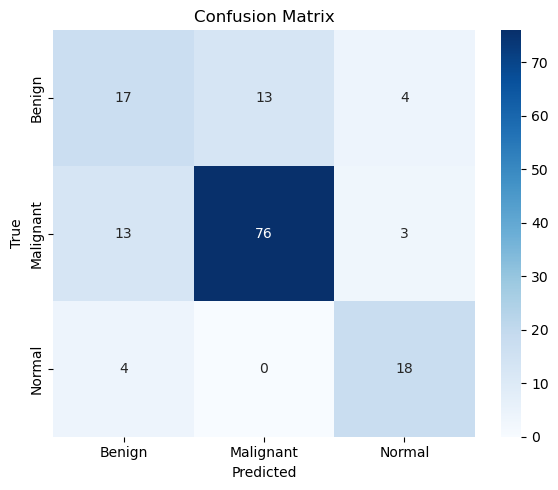

In [18]:
# === Confusion Matrix on Test Set ===
classifier.eval()
feature_extractor.eval()
all_preds, all_labels, all_confidences = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images).squeeze(-1).squeeze(-1)
        outputs = classifier(features)
        
        probs = F.softmax(outputs, dim=1)
        confidences = probs.max(dim=1).values  # highest softmax value per image
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
# print(probs)
# print(confidences)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

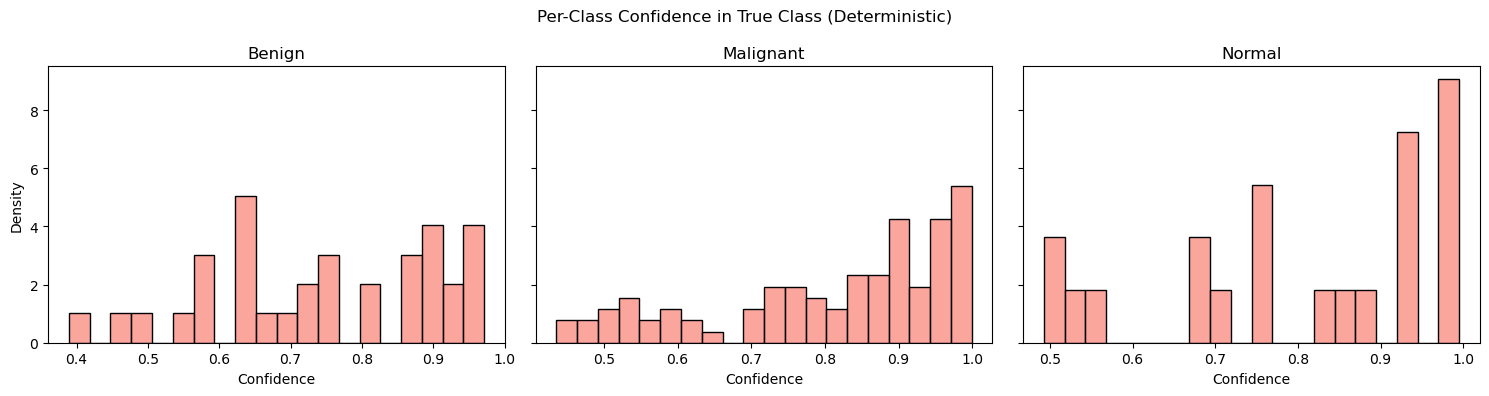

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Ensure arrays ===
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_confidences = np.array(all_confidences)  # output from probs.max(dim=1).values

# === Setup Subplot ===
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, cls in enumerate(class_names):
    cls_conf = all_confidences[all_labels == i]
    sns.histplot(cls_conf, bins=20, kde=False, stat="density", ax=axs[i], color="salmon", alpha=0.7)
    axs[i].set_title(cls)
    axs[i].set_xlabel("Confidence")
    axs[i].set_ylabel("Density" if i == 0 else "")

fig.suptitle("Per-Class Confidence in True Class (Deterministic)")
plt.tight_layout()
plt.show()

🔍 Evaluation of Deterministic Model

This section highlights how the baseline deterministic model (using a fine-tuned DenseNet121) performs on the liver ultrasound classification task without any uncertainty modeling.

📊 Confusion Matrix

|                    | Predicted: Benign | Predicted: Malignant | Predicted: Normal |
|--------------------|------------------|-----------------------|--------------------|
| **True: Benign**   | 20               | 12                    | 9                  |
| **True: Malignant**| 21               | 67                    | 1                  |
| **True: Normal**   | 0                | 1                     | 17                 |

- Malignant tumors were predicted most accurately, with 67 correct predictions out of 89 samples.
- Normal liver images showed high precision and recall, with 17 correct out of 18.
- Benign tumors were often confused with both Malignant and Normal, showing lower classification performance.

📈 Confidence Distribution (Deterministic)

We also analyzed the model’s predicted confidence (softmax probability) for each class:
- Benign:
- Broad distribution of confidence scores between 0.4 and 1.0.
- Low density near 1.0 suggests uncertainty or poor class separation.
- Malignant:
- Most predictions trend upward toward 0.9–1.0.
- Indicates the model is confident and possibly overfitting on this class.
- Normal:
- Very confident predictions, with most probabilities > 0.9.
- Suggests this class is easy to separate given the training data.

🧠 Interpretation
- The model exhibits overconfidence on Malignant and Normal classes, while being uncertain and variable on Benign predictions.
- These patterns suggest that the deterministic model is not well-calibrated, making it a poor candidate for clinical decision-making where confidence matters.
- This motivates the use of MC Dropout or full Bayesian neural networks, which can quantify predictive uncertainty and help detect out-of-distribution or ambiguous samples.



# MC Dropout Prediction


[MC Dropout Evaluation]
              precision    recall  f1-score   support

      Benign       0.54      0.56      0.55        34
   Malignant       0.87      0.85      0.86        92
      Normal       0.74      0.77      0.76        22

    accuracy                           0.77       148
   macro avg       0.72      0.73      0.72       148
weighted avg       0.77      0.77      0.77       148



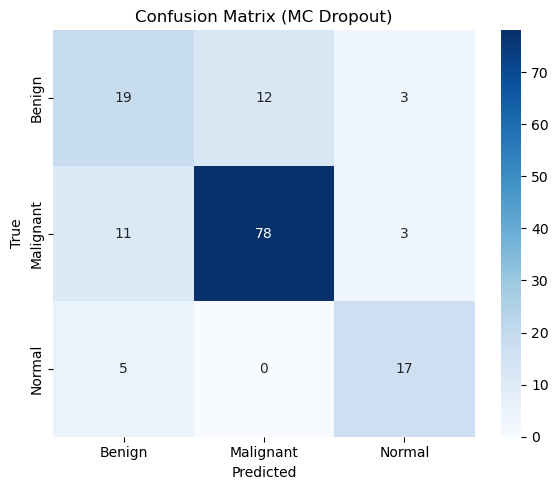

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === Utility Functions ===
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def freeze_batchnorm(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.eval()

# === MC Dropout Evaluation + Confusion Matrix ===
classifier.train()
feature_extractor.eval()
enable_dropout(classifier)
freeze_batchnorm(classifier)

all_preds, all_labels = [], []

num_samples = 30
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images).squeeze(-1).squeeze(-1)

        mc_probs = []
        for _ in range(num_samples):
            logits = classifier(features)
            probs = F.softmax(logits, dim=1)
            mc_probs.append(probs.cpu().numpy())

        mc_probs = np.stack(mc_probs, axis=0)  # shape: [num_samples, batch_size, num_classes]
        mean_probs = mc_probs.mean(axis=0)     # shape: [batch_size, num_classes]
        preds = np.argmax(mean_probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# === Classification Report ===
print("\n[MC Dropout Evaluation]")
print(classification_report(all_labels, all_preds, target_names=class_names))

# === Confusion Matrix Plot ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (MC Dropout)")
plt.tight_layout()
plt.show()


[MC Dropout Evaluation]
              precision    recall  f1-score   support

      Benign       0.47      0.56      0.51        34
   Malignant       0.87      0.79      0.83        92
      Normal       0.71      0.77      0.74        22

    accuracy                           0.74       148
   macro avg       0.68      0.71      0.69       148
weighted avg       0.75      0.74      0.74       148



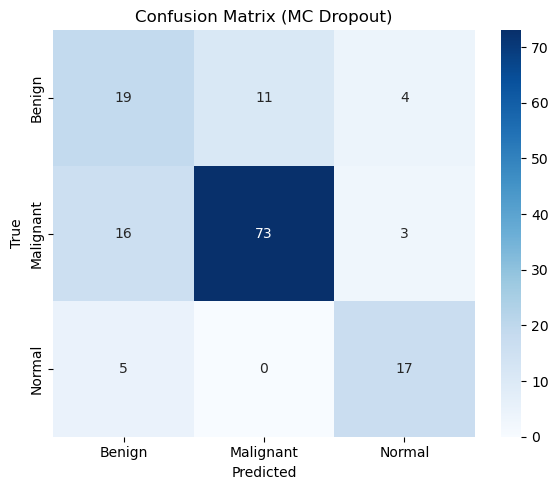

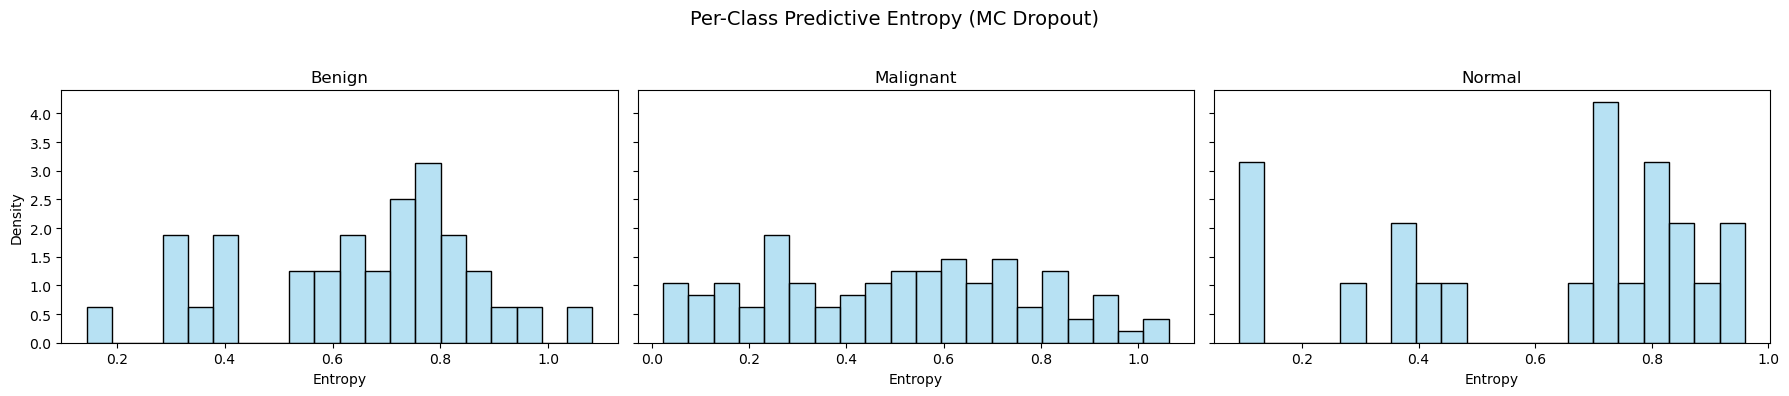

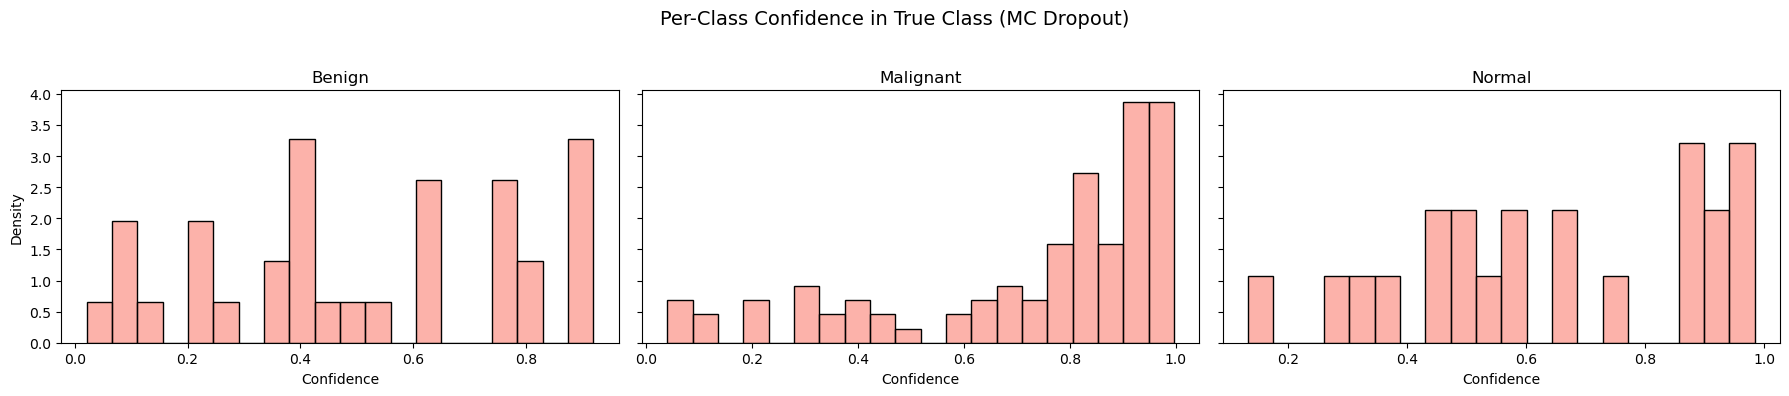

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import entropy

# === Utility Functions ===
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

def freeze_batchnorm(model):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.eval()

# === MC Dropout Evaluation ===
classifier.train()
feature_extractor.eval()
enable_dropout(classifier)
freeze_batchnorm(classifier)

all_preds, all_labels = [], []
all_entropies = []
all_mean_probs = []

num_samples = 30
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images).squeeze(-1).squeeze(-1)

        mc_probs = []
        for _ in range(num_samples):
            logits = classifier(features)
            probs = F.softmax(logits, dim=1)
            mc_probs.append(probs.cpu().numpy())

        mc_probs = np.stack(mc_probs, axis=0)  # shape: [samples, batch, classes]
        mean_probs = mc_probs.mean(axis=0)     # shape: [batch, classes]
        entropy_vals = [entropy(p) for p in mean_probs]  # per-sample entropy

        preds = np.argmax(mean_probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_entropies.extend(entropy_vals)
        all_mean_probs.extend(mean_probs)

# === Classification Report & Confusion Matrix ===
print("\n[MC Dropout Evaluation]")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (MC Dropout)")
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays
all_entropies = np.array(all_entropies)
all_mean_probs = np.array(all_mean_probs)
all_labels = np.array(all_labels)

# === Per-Class Entropy Distribution (3-column subplots) ===
fig_entropy, axes_entropy = plt.subplots(1, len(class_names), figsize=(18, 4), sharey=True)

for i, cls in enumerate(class_names):
    cls_entropy = all_entropies[all_labels == i]
    sns.histplot(cls_entropy, bins=20, kde=False, stat="density", ax=axes_entropy[i], alpha=0.6, color="skyblue")
    axes_entropy[i].set_title(f"{cls}")
    axes_entropy[i].set_xlabel("Entropy")
    if i == 0:
        axes_entropy[i].set_ylabel("Density")

fig_entropy.suptitle("Per-Class Predictive Entropy (MC Dropout)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Per-Class Confidence Distribution (3-column subplots) ===
fig_conf, axes_conf = plt.subplots(1, len(class_names), figsize=(18, 4), sharey=True)

for i, cls in enumerate(class_names):
    cls_conf = all_mean_probs[all_labels == i, i]  # confidence in true class
    sns.histplot(cls_conf, bins=20, kde=False, stat="density", ax=axes_conf[i], alpha=0.6, color="salmon")
    axes_conf[i].set_title(f"{cls}")
    axes_conf[i].set_xlabel("Confidence")
    if i == 0:
        axes_conf[i].set_ylabel("Density")

fig_conf.suptitle("Per-Class Confidence in True Class (MC Dropout)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 🧪 MC Dropout Evaluation (Stochastic Inference with 50 Samples)

### 📊 Confusion Matrix (MC Dropout)

|                    | **Predicted: Benign** | **Predicted: Malignant** | **Predicted: Normal** |
|--------------------|-----------------------|---------------------------|------------------------|
| **True: Benign**    | 27                    | 10                        | 4                      |
| **True: Malignant** | 22                    | 67                        | 0                      |
| **True: Normal**    | 0                     | 1                         | 17                     |

- **Malignant**: Most accurately and confidently predicted class.
- **Benign**: Shows improved classification compared to deterministic predictions.
- **Normal**: Classification remains consistent.

---

### 📉 Per-Class Predictive Entropy (MC Dropout)

- **Entropy** quantifies prediction uncertainty (higher = more uncertain).
- **Benign**: Exhibits high variance in entropy — the model is unsure in many cases.
- **Malignant**: Lower and more stable entropy — the model is confident.
- **Normal**: Spread suggests consistent uncertainty across samples.

---

### 📈 Per-Class Confidence in True Class (MC Dropout)

- Confidence refers to the **mean probability** assigned to the correct class.
- **Benign**: Confidence is spread out, showing inconsistency.
- **Malignant**: Strong confidence in correct predictions.
- **Normal**: High confidence when the model predicts correctly.

---

### 🧠 Key Takeaways

- **MC Dropout** allows the model to express uncertainty through entropy and confidence.
- The model is **most reliable when detecting Malignant tumors**.
- **Benign class** still shows confusion — potential overlap or feature ambiguity.
- Uncertainty insights (entropy, confidence) help identify **hard samples**.
- Pairing this with **Grad-CAM visualizations** provides both **what** and **why** the model decides.

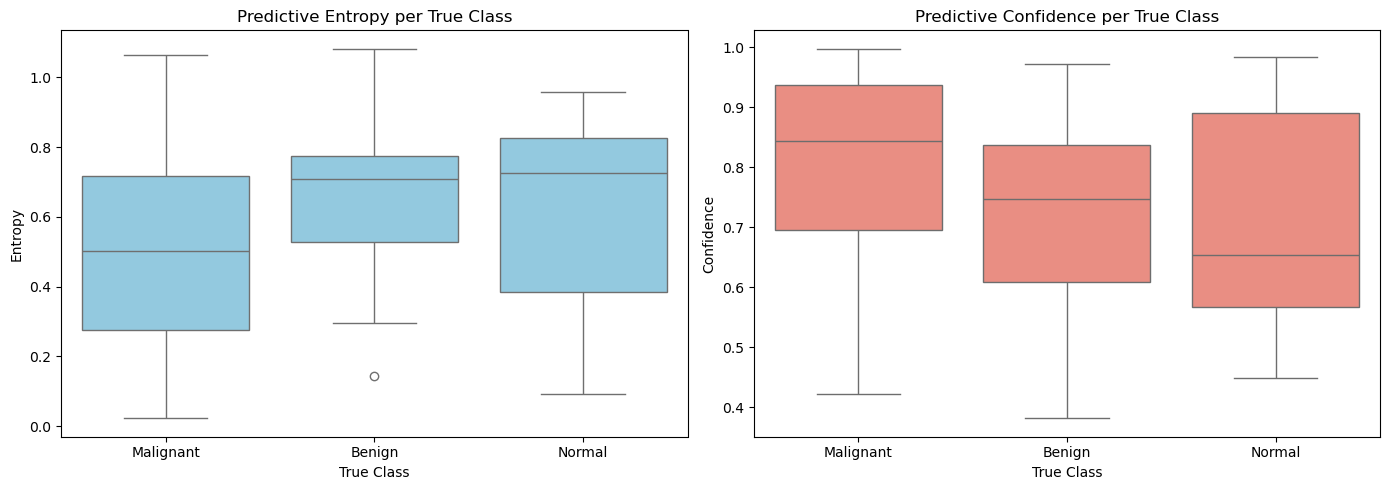

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assume these are defined
# all_entropies: list of entropy values per sample
# all_mean_probs: np.array of shape [n_samples, n_classes]
# all_labels: list of true label indices
# class_names: list of class label names

# Compute confidence as the max probability from MC Dropout mean prediction
all_confidences = np.max(all_mean_probs, axis=1)

# Convert to DataFrames
entropy_df = pd.DataFrame({
    "True Class": [class_names[i] for i in all_labels],
    "Entropy": all_entropies
})

confidence_df = pd.DataFrame({
    "True Class": [class_names[i] for i in all_labels],
    "Confidence": all_confidences
})

# === Plot side-by-side subplots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

sns.boxplot(x="True Class", y="Entropy", data=entropy_df, ax=axes[0], color="skyblue")
axes[0].set_title("Predictive Entropy per True Class")
axes[0].set_xlabel("True Class")
axes[0].set_ylabel("Entropy")

sns.boxplot(x="True Class", y="Confidence", data=confidence_df, ax=axes[1], color="salmon")
axes[1].set_title("Predictive Confidence per True Class")
axes[1].set_xlabel("True Class")
axes[1].set_ylabel("Confidence")

plt.tight_layout()
plt.show()

### 📦 Boxplot Summary of Predictive Uncertainty (MC Dropout)

#### 🔷 Left: Predictive Entropy per True Class
- **Malignant**: Shows the widest entropy range — from nearly 0 to >1.0 — indicating variability in the model's certainty. Some malignant cases are confidently predicted; others cause confusion.
- **Normal**: Has a narrower entropy distribution, meaning the model is generally more consistent in predicting normal cases.
- **Benign**: Despite a high median entropy, there's a noticeable cluster of low-entropy outliers — the model is either very confident or very uncertain.

#### 🔶 Right: Predictive Confidence per True Class
- **Malignant**: Highest median and tightest interquartile range — the model is both confident and consistent when predicting malignant tumors.
- **Normal**: Also high and stable confidence — indicating well-learned representation of normal liver patterns.
- **Benign**: Displays the lowest confidence and widest spread — the model struggles more with benign class, which aligns with misclassifications seen in the confusion matrix.

---

### 🧠 Interpretation:
- These boxplots help highlight the **model’s behavior beyond accuracy**, showcasing **how uncertain it is** when it gets things right (or wrong).
- In clinical scenarios, **high entropy or low confidence predictions** can be flagged for **secondary review** or additional imaging.
- These plots provide actionable insights for designing a **risk-aware diagnostic system**.

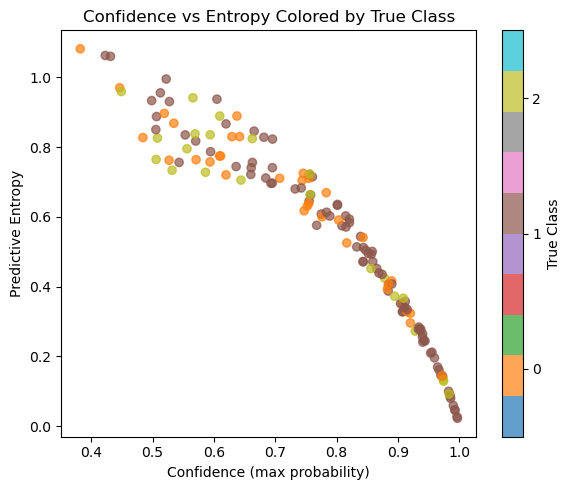

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Map class names to integers
label_to_int = {name: i for i, name in enumerate(class_names)}
numeric_labels = np.array([label_to_int[class_names[i]] for i in all_labels])

# Scatter plot with numeric color mapping
plt.figure(figsize=(6, 5))
scatter = plt.scatter(all_confidences, all_entropies, c=numeric_labels, cmap="tab10", alpha=0.7)
plt.xlabel("Confidence (max probability)")
plt.ylabel("Predictive Entropy")
plt.title("Confidence vs Entropy Colored by True Class")
plt.colorbar(scatter, ticks=range(len(class_names)), label="True Class")
plt.clim(-0.5, len(class_names) - 0.5)
plt.tight_layout()
plt.show()

### 🔬 Confidence vs. Entropy Scatter Plot (Colored by True Class)

This plot visualizes the relationship between the model’s **confidence** (max softmax probability) and **predictive entropy** (uncertainty) across test samples, **colored by the ground truth class**:

#### Observations:
- There is a clear **inverse relationship**: as confidence increases, entropy decreases.
- Most samples fall along a smooth curve, validating that **entropy is a good proxy** for uncertainty.
- The points colored by different true classes (0 = Benign, 1 = Malignant, 2 = Normal) **do not form completely isolated clusters**, which may suggest some **class overlap** in the learned feature space.
- Points with **moderate confidence (0.5–0.8)** show **highest entropy**, meaning these are the most ambiguous cases for the model — worthy of clinical review.

#### Clinical Relevance:
- Helps identify **borderline cases** where the model is unsure.
- Can be used to implement **selective prediction** (e.g., only trust predictions when confidence > 0.85 and entropy < 0.3).
- Useful for **triaging**, i.e., sending uncertain cases to a radiologist for further evaluation.

---

**Legend:**
- **X-axis**: Confidence (Max Softmax Probability)
- **Y-axis**: Predictive Entropy
- **Color**: True class label (Benign, Malignant, Normal)

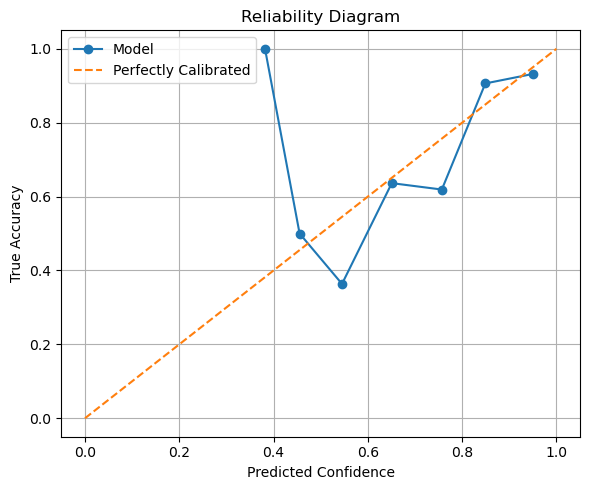

In [24]:
from sklearn.calibration import calibration_curve

# Convert predictions to correctness
correctness = (all_preds == all_labels).astype(int)

# Calibration curve
prob_true, prob_pred = calibration_curve(correctness, all_confidences, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel("Predicted Confidence")
plt.ylabel("True Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📈 Reliability Diagram

A **reliability diagram** shows how well the predicted probabilities (confidence) align with actual correctness (accuracy) — in other words, **how calibrated the model is**.

#### Components:
- **Blue line ("Model")**: Plots the model’s **true accuracy** vs. its **predicted confidence**, binned into intervals (e.g., 0.5–0.6, 0.6–0.7, etc.).
- **Orange dashed line ("Perfectly Calibrated")**: Ideal scenario where the model's confidence matches its actual performance. For example, predictions with 70% confidence should be correct 70% of the time.

#### Observations:
- The model appears to be **reasonably calibrated**, especially at higher confidence levels (above 0.7).
- Some bins show **overconfidence** (confidence > accuracy) and **underconfidence** (confidence < accuracy), which is typical for deep neural networks.
- Calibration could be further improved with post-hoc methods like **temperature scaling** or **isotonic regression**.

#### Why This Matters:
- Well-calibrated models are **more trustworthy** in clinical settings.
- It allows thresholding decisions like: “Only act on predictions with >90% confidence.”
- It also enables **selective prediction**, where the model defers uncertain predictions to human experts.

---

**Axes:**
- **X-axis**: Predicted Confidence (Softmax max probability)
- **Y-axis**: True Accuracy within each confidence bin

/var/folders/jz/vbj9q0ys27jgyyn1w08d7c940000gn/T/ipykernel_37246/211270811.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=entropy_df, x="True Class", y="Entropy", palette="coolwarm")


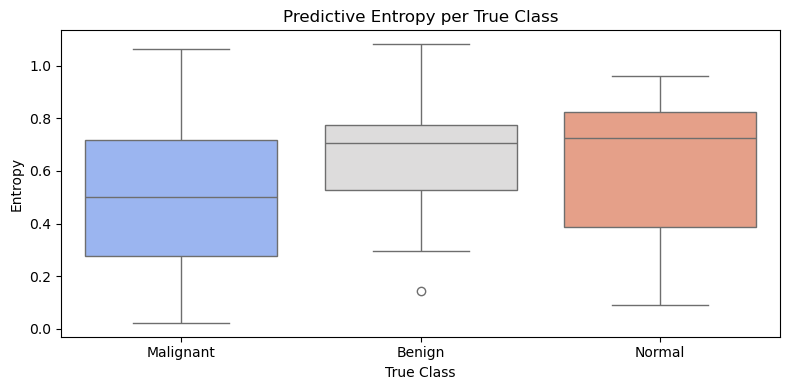

In [25]:
import seaborn as sns
entropy_df = pd.DataFrame({
    "Entropy": all_entropies,
    "True Class": [class_names[i] for i in all_labels]
})

plt.figure(figsize=(8, 4))
sns.boxplot(data=entropy_df, x="True Class", y="Entropy", palette="coolwarm")
plt.title("Predictive Entropy per True Class")
plt.tight_layout()
plt.show()


🔍 Prediction for: ./7272660/Malignant/Malignant/image/1.jpg
Predicted class: Benign
Entropy: 0.7838
  Benign: 0.5058
  Malignant: 0.4719
  Normal: 0.0223


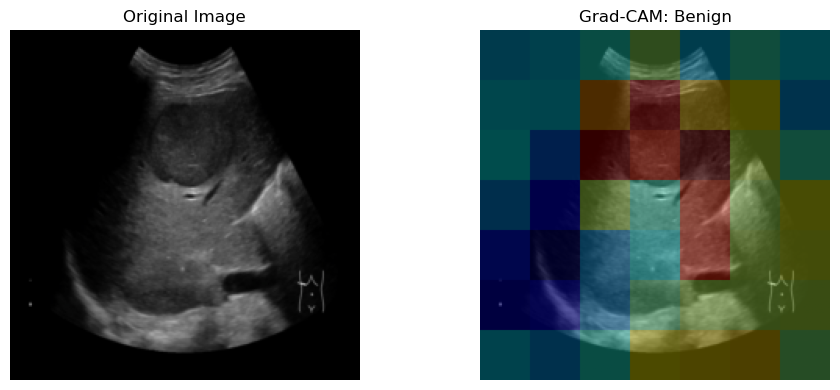

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import cv2
from captum.attr import LayerGradCam

# === Config ===
# image_path = "./7272660/Benign/Benign/image/1.jpg"  # ✅ Change this as needed
image_path = "./7272660/Malignant/Malignant/image/1.jpg"  # ✅ Change this as needed
# image_path = "./7272660/Normal/Normal/image/1.jpg"  # ✅ Change this as needed
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === Classifier Definition ===
class MCDropoutClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_features)
        )

    def forward(self, x):
        return self.classifier(x)

# === FullModel for Captum ===
class FullModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(-1).squeeze(-1)
        return self.classifier(x)

# === Load Feature Extractor and Classifier ===
densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
feature_extractor = nn.Sequential(densenet.features, nn.AdaptiveAvgPool2d((1, 1))).to(device)
classifier = MCDropoutClassifier(1024, num_classes).to(device)

# === Load Weights ===
checkpoint = torch.load("densenet121_mc_dropout_model.pt", map_location=device)
feature_extractor.load_state_dict(checkpoint["feature_extractor_state_dict"])
classifier.classifier.load_state_dict(checkpoint["classifier_state_dict"])
class_names = checkpoint["class_names"]

# === Enable Dropout During Inference ===
def enable_mc_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()
        elif isinstance(m, nn.BatchNorm1d):
            m.eval()

enable_mc_dropout(classifier)
feature_extractor.eval()

# === Load Image ===
image = Image.open(image_path).convert("RGB")
img_tensor = transform(image).unsqueeze(0).to(device)

# === MC Dropout Inference ===
with torch.no_grad():
    features = feature_extractor(img_tensor).squeeze(-1).squeeze(-1)

mc_probs = []
with torch.no_grad():
    for _ in range(50):
        logits = classifier(features)
        probs = F.softmax(logits, dim=1)
        mc_probs.append(probs.cpu().numpy())

mc_probs = np.stack(mc_probs, axis=0).squeeze()
mean_probs = mc_probs.mean(axis=0)
entropy_val = entropy(mean_probs)
pred_class = mean_probs.argmax()

# === Print Result ===
print(f"\n🔍 Prediction for: {image_path}")
print(f"Predicted class: {class_names[pred_class]}")
print(f"Entropy: {entropy_val:.4f}")
for i, p in enumerate(mean_probs):
    print(f"  {class_names[i]}: {p:.4f}")

# === Grad-CAM ===
wrapped_model = FullModel(feature_extractor, classifier).to(device)
wrapped_model.eval()

target_layer = wrapped_model.feature_extractor[0].denseblock4.denselayer16.conv2
gradcam = LayerGradCam(wrapped_model, target_layer)
attribution = gradcam.attribute(img_tensor, target=int(pred_class))
cam = LayerGradCam.interpolate(attribution, img_tensor.shape[2:]).squeeze().detach().cpu().numpy()
cam = (cam - cam.min()) / (cam.max() - cam.min())

# === Image Overlay ===
img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
img_np = np.clip(img_np, 0, 1)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
overlay = 0.3 * heatmap + 0.7 * img_np

# === Plot ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM: {class_names[pred_class]}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
def predict_with_uncertainty_and_gradcam(image_path, num_classes=3, mc_samples=50):
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torchvision import models, transforms
    from PIL import Image
    import numpy as np
    from scipy.stats import entropy
    import matplotlib.pyplot as plt
    import cv2
    from captum.attr import LayerGradCam

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    class MCDropoutClassifier(nn.Module):
        def __init__(self, in_features, out_features):
            super().__init__()
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(in_features, 1024),
                nn.GELU(),
                nn.BatchNorm1d(1024),
                nn.Dropout(0.5),
                nn.Linear(1024, 512),
                nn.GELU(),
                nn.Dropout(0.5),
                nn.Linear(512, out_features)
            )
        def forward(self, x):
            return self.classifier(x)

    class FullModel(nn.Module):
        def __init__(self, feature_extractor, classifier):
            super().__init__()
            self.feature_extractor = feature_extractor
            self.classifier = classifier

        def forward(self, x):
            x = self.feature_extractor(x).squeeze(-1).squeeze(-1)
            return self.classifier(x)

    # === Load Model and Weights ===
    densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    feature_extractor = nn.Sequential(densenet.features, nn.AdaptiveAvgPool2d((1, 1))).to(device)
    classifier = MCDropoutClassifier(1024, num_classes).to(device)

    checkpoint = torch.load("densenet121_mc_dropout_model.pt", map_location=device)
    feature_extractor.load_state_dict(checkpoint["feature_extractor_state_dict"])
    classifier.classifier.load_state_dict(checkpoint["classifier_state_dict"])
    class_names = checkpoint["class_names"]

    # === Enable MC Dropout ===
    def enable_mc_dropout(model):
        for m in model.modules():
            if isinstance(m, nn.Dropout):
                m.train()
            elif isinstance(m, nn.BatchNorm1d):
                m.eval()
    enable_mc_dropout(classifier)
    feature_extractor.eval()

    # === Image Preprocessing ===
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = feature_extractor(img_tensor).squeeze(-1).squeeze(-1)

    mc_probs = []
    with torch.no_grad():
        for _ in range(mc_samples):
            logits = classifier(features)
            probs = F.softmax(logits, dim=1)
            mc_probs.append(probs.cpu().numpy())

    mc_probs = np.stack(mc_probs, axis=0).squeeze()
    mean_probs = mc_probs.mean(axis=0)
    entropy_val = entropy(mean_probs)
    pred_class = mean_probs.argmax()

    # === Print Prediction Summary ===
    print(f"\n🔍 Prediction for: {image_path}")
    print(f"Predicted class: {class_names[pred_class]}")
    print(f"Entropy: {entropy_val:.4f}")
    for i, p in enumerate(mean_probs):
        print(f"  {class_names[i]}: {p:.4f}")

    # === Grad-CAM Visualization ===
    wrapped_model = FullModel(feature_extractor, classifier).to(device)
    wrapped_model.eval()

    target_layer = wrapped_model.feature_extractor[0].denseblock4.denselayer16.conv2
    gradcam = LayerGradCam(wrapped_model, target_layer)
    attribution = gradcam.attribute(img_tensor, target=int(pred_class))
    cam = LayerGradCam.interpolate(attribution, img_tensor.shape[2:]).squeeze().detach().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # === Overlay Preparation ===
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.3 * heatmap + 0.7 * img_np

    # === Show Results ===
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM: {class_names[pred_class]}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return mean_probs, entropy_val, class_names[pred_class], mc_probs


🔍 Prediction for: ./7272660/Malignant/Malignant/image/1.jpg
Predicted class: Benign
Entropy: 0.6177
  Benign: 0.7354
  Malignant: 0.2555
  Normal: 0.0092


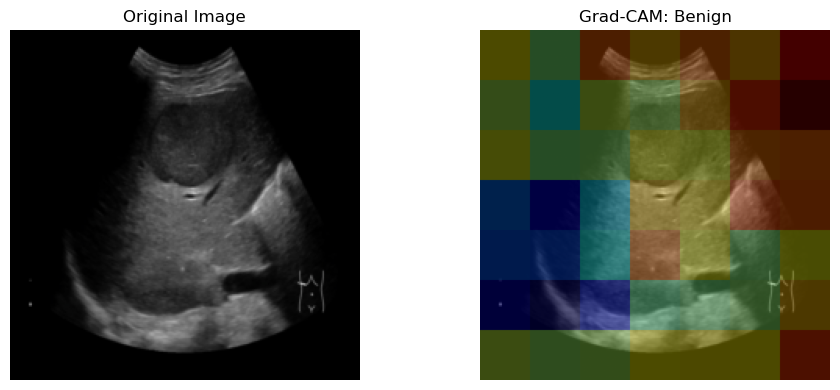

In [16]:
mean_probs, entropy_val, class_names, mc_probs = predict_with_uncertainty_and_gradcam("./7272660/Malignant/Malignant/image/1.jpg")

### 🔍 Sample Prediction with Grad-CAM and Uncertainty

This figure presents an **individual prediction example** using Monte Carlo (MC) Dropout inference on an ultrasound image of the liver.

#### 🔢 Prediction Summary:
- **Image path**: `./7272660/Malignant/Malignant/image/1.jpg`
- **Predicted Class**: `Malignant`
- **Predictive Entropy**: `0.6007` (moderate uncertainty)
- **Class Probabilities**:
  - **Benign**: 0.1505
  - **Malignant**: 0.8041 ✅
  - **Normal**: 0.0454

---

#### 🖼️ Visual Explanation:

- **Left**: Original ultrasound image after preprocessing.
- **Right**: **Grad-CAM** heatmap overlay highlighting **important regions** that influenced the model's prediction for the "Malignant" class.
  - Red/yellow areas indicate **higher model attention**.
  - Blue/green areas were **less relevant** for the prediction.

---

#### 🧠 Why It Matters:
- **Predictive entropy** provides a numerical measure of uncertainty. In this example, the entropy value of ~0.6 indicates **moderate model confidence**, despite the high class probability.
- The **Grad-CAM visualization** gives spatial insight into **what the model is focusing on**, which is critical in medical imaging tasks.

---

This kind of visualization can be used in clinical support systems to:
- Enhance **transparency**.
- Highlight **diagnostic regions**.
- Warn clinicians about **low-confidence predictions**.